In [147]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as modsel
import sklearn.preprocessing as preproc

<b><h3>The Effects of Feature Scaling: From Bag-of-Words to Tf-Idf</h3></b>

A bag-of-words representation is simple to generate but far from perfect. If we caount all words equally, then some words end up being emphasized more than we need. We'd like a document representation that emphasizes the most meaningful words, such as the main characters of of a story, words that indicate sentiment.

<b><h3>Tf-Idf: A Simple Twist on Bag-of-Words</h3></b>

Tf-Idf is a simple twist on the bag-of-words approach. It stands for term frequency inverse document frequency. Instead of looking at raw counts of each word in each document in a dataset, tf-idf looks at a normalized count where each word count is divided by the number of documents this word appears in. That is 

bow(w,d) = # times word w appears in document d

tf-idf(w,d) = bow(w,d)* N / (# documents in which word w appears)

N is the total number of documents. The fraction N / (# documents) is what's known as the inverse document frequency. If a word appears in many documents, then its inverse document frequency is close to 1. If a word appears in just a few documents, then is inverse document frequency is much higher.

Alternatively, we can take a log transform instead of using the raw inverse document frequency. Logarithm turns 1 into 0, and makes large numbers smaller. If we define tf-idf as:

tf-idf(w,d) = bow(w,d) * log( N / # documents in which word w appears)

then a word that appears in every single document will effectively be zeroed out, and a word that appears in a very few documents will have an even larger count than before. Thus, tf-idf makes rare words more prominent and effectively ignores common words. 

<b><h4>Putting It to the Test</h4></b>

Tf-idf transforms word count features through multiplication with a constant. Hence, it is an example of feature scaling. 

In [148]:
review_df = pd.read_csv('../datasets/yelp.csv')

In [149]:
review_df.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')

In [150]:
# target signifies whether customer liked their experience - binarization of target, 
# apply to each row of series, and for apply, method that equates to axis=1 or 'columns', because we treat the rows 
# in each column as a group, find the 'stars' index and check if its value is greater than or equal to 3.
review_df['target'] = review_df.apply(lambda x: x['stars'] >= 3, axis='columns') 

In [151]:
review_df.target.unique()

array([ True, False])

In [152]:
training_data, test_data = modsel.train_test_split(review_df, train_size=0.7, random_state=123)

In [153]:
training_data.shape

(7000, 11)

In [154]:
test_data.shape

(3000, 11)

<b><h4>Scaling Bag-of-Words with Tf-Idf Transformation</h4></b>

The goal of this experiment is to compare the effectiveness of bag-of-words, tf-idf, and l<sup>2</sup> normalization for linear classification. Note that doing tf-idf then l<sup>2</sup> normalization is the same as doing l<sup>2</sup> normalization alone. So we only need to test three sets of features: bag-of-words, tf-idf, and word-wise l<sup>2</sup> normalization on top of bag-of-words.

We use scikit-learn's CountVectorizer to convert the review text into a bag-of-words. All text featurization methods implicitly depend on a tokenizer, which is the module that converts a text string into a list of tokens (words). Here, scikit-learn's default tokenizing pattern looks for sequences of two or more alphanumeric characters. Punctation marks are treated as token separators.

When we use training statistics to scale test data, the result will look a little fuzzy. Min_max scaling on the test on the test set no longer neatly maps to 0 and 1. l<sup>2</sup> norms, mean, and variance statistics will all look a little off. This is less problematic than missing data. For instance, the test set may contain words that are not present in the training data, and we would have no document frequencyy to use the new words. The common solution is simply drop the new words in the test set. This may seem irresponsible, but the model- trained on the training set= would not know what to do with these words anyway. A slightly less hacky option would be to explicitly learn a 'garbage' word and map all low-frequency words to it, even within the training set.

In [155]:
bow_transform = text.CountVectorizer()   # initialize transformer
X_tr_bow = bow_transform.fit_transform(training_data['text'])  # feed only the input
X_te_bow = bow_transform.transform(test_data['text'])
len(bow_transform.vocabulary_)

24980

In [156]:
y_tr = training_data['target']  # store the target
y_te = test_data['target']

In [157]:
X_tr_bow.shape

(7000, 24980)

In [158]:
# Create the tf-idf representation using the bag-of-words matrix

tfidf_trfm = text.TfidfTransformer(norm=None)  # initialize transformer
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow) # bag-of-words of training data go into tfidf transformer
X_te_tfidf = tfidf_trfm.transform(X_te_bow) # avoid data leakage by using training data parameters on test

In [159]:
# l2-normalzie the bag-of-words representation
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0) # normalize the features, axis=0
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

A subtle point about feature scaling is that it requires knowing feature statistics that we most likely do not know in practice, such as the mean, variance, document frequency, l<sup>2</sup> norm, etc. In order to compute the tf-idf representation we have to compute the inverse document frequencies based on the training data and use these statistics to scale both the training and test data. In scikit-learn, fitting the feature transformer on the training data amounts to collecting the relevant statistics. The fitted transformer can then be applied to the test data.

<b><h4>Classification with Logistic Regression</h4></b>

Logistic regression is a simple, linear classifier. Due to its simplicity, its often a good first classifier to try. It takes a weighted combination of the input features, and passes it through a sigmoid function, which smoothly maps any real number to a number between 0 and 1. The function transforms a real number input, x, into a number between 0 and 1. It has one set of parameters, w, which represents the slope of the increase around the midpoint, 0.5. The intercept b denotes the input value where the output crosses the midpoint. A logistic classifier would predict the positive class if the sigmoid output is greater than 0.5 and the negative class otherwise. By varying w and b, one can control where that change in decision occurs, and how fast the decision should respond to changing input values around that point.

In [160]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0, ):
    """ Helper function to train a logistic classifier and score on that data"""
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print(f"Test with score with {description} features: {s*100:.3f}%")
    return m

In [161]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bag-of-words')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf_idf')

/Users/godfredowusu/Desktop/mlbooklearn/tfenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test with score with bag-of-words features: 89.067%
Test with score with l2-normalized features: 85.633%
Test with score with tf_idf features: 88.900%


/Users/godfredowusu/Desktop/mlbooklearn/tfenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Paradoxically, the results show that the most accurate classifier is the one using bag-of-words features. This was unexpected. As it turns out, the reason is that the classifiers are not well 'tuned', which is a common pitfall when comparing classifiers.

<b><h4>Tuning Logistic Regression</h4></b>

Logisitic regression has a few bells and whistles. When the number of features is greater than the number of data points, the problem of finding the best model is said to be underdetermined. One way to fix this problem is by placing addtional constraints on the training process. This is known as regularization.

In order to allow for regularization we must specify a regularization parameter. Regularization parameters are hyperparameters that are not learned automatically in the model training process. Rather, they must be tuned on the problem at hand and given to the training algorithm. This process is known as hyperparameter tuning.

One basic method for tuning hyperparameters is called grid search: you specify a grid of hyperparameter values and the tuner programmaatically searches for the best hyperparameter setting in the grid. After finding the best hyperparameter settiing, you train a model on the entire training set using that setting, and use its performance on the test set as the final evaluation of this class of models.

<b><h4>Cross Validation</h4></b>

We also want to test whether the difference in accuracy between tf-idf and bag-of-words is due to noise. To this end, we use k-fold cross validation to simulate having multiple statistically independent datasets. It divides the dataset into k folds. The cross validation process iterates through the folds, using all but one fold for training, and validating the results on the fold that is held out. 

The GridSearchCV() funcition in scikit-learn runs a grid search with cross validation.

<b><h4>Tune Hyperparameters When Comparing Models</h4></b>

It's essential to tune hyperparameters when comparing models or features. The default settings of a software package will always return a model. But unless the software performs automatic tuning under the hood, it is likely to return a suboptimal model based on suboptimal hyperparameter settings. The sensitivity of classifier performance on hyperparameter settings depends on the model and the distribution of the training data. Logistic regression is relatively robust (or insensitive) to hyperparameter settings. Even so, it is necessary to find and use the right range of hyperparameters. Otherwise, the advantages of one model versus another may be due solel due to tuning parameters, and will not reflect the actual behavior of the model or features. Even the best autotuning packages still require specifying the upper and lower limits of search, and finding those limits can take a few manual tries.

<b><h4>Estimating Variance via Resampling</h4></b>

Modern statistical methods assume that the underlying data comes from a random distribution. The performance measurements of models derived from data are also subject to random noise. In this situation it is always a good idea to take the measurement not just once, but multiple times, based on datasets of comparable statistics. This gives us a confidence interval for the measurement. k-fold cross validation is one such strategy. Resampling is another technique that generates multiple small smaples from the same underlying dataset.

In [162]:
# Tuning logisitc regression hyperparmeters with grid search

# Specify a search grid, then do a 5-fold grid search for each of the feature sets
param_grid_ = {'C':[1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

# Tune classifier for bag-of-words representation
bow_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_) # instantiate grid
bow_search.fit(X_tr_bow, y_tr) # run the k-fold cv grid search

# Tune classifier for L2-normalized word vector
l2_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
l2_search.fit(X_tr_l2, y_tr)

# Tune classifier for tf-idf
tfidf_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search.fit(X_tr_tfidf,y_tr)

/Users/godfredowusu/Desktop/mlbooklearn/tfenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/godfredowusu/Desktop/mlbooklearn/tfenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [163]:
# Let's check out one of the grid search outputs to see how it went
bow_search.cv_results_

{'mean_fit_time': array([0.10338268, 0.18638144, 0.38504958, 0.39609017, 0.4525372 ,
        0.42367635]),
 'std_fit_time': array([0.03779055, 0.02903081, 0.02645252, 0.05596991, 0.03757431,
        0.03764445]),
 'mean_score_time': array([0.00061378, 0.00062571, 0.00060487, 0.00063524, 0.00086622,
        0.00069604]),
 'std_score_time': array([2.23847495e-05, 2.61846563e-05, 5.51945962e-05, 8.68596023e-05,
        8.25957665e-05, 9.86000320e-05]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.83428571, 0.84785714, 0.89428571, 0.89714286, 0.89285714,
        0.88857143]),
 'split1_test_score': array([0.83428571, 0.84928571, 0.89      , 0.89071429, 0.89571429,
        0.88428571]),
 'split2_test_score': array([0.8342857

In [164]:
# Plot the cross validation results in a box-and-whiskers plot to visualize and compare classifier performance
search_results = pd.DataFrame.from_dict({
    'bow'   : bow_search.cv_results_['mean_test_score'],
    'tfidf' : tfidf_search.cv_results_['mean_test_score'],
    'l2'    : l2_search.cv_results_['mean_test_score']
})

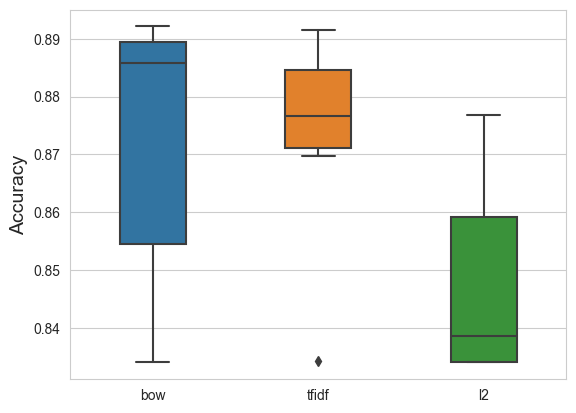

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=10)

In [166]:
search_results

,bow,tfidf,l2
0,0.834000,0.834286,0.834000
1,0.845000,0.877857,0.834000
2,0.892143,0.891571,0.834000
3,0.889714,0.886857,0.843143
4,0.888714,0.875571,0.864429
5,0.883000,0.869714,0.876857


In [167]:
search_results.index = pd.Index(param_grid_['C'])
search_results.index.name = 'regularization parameter'

In [168]:
search_results

,bow,tfidf,l2
regularization parameter,,,
0.00001,0.834000,0.834286,0.834000
0.00100,0.845000,0.877857,0.834000
0.10000,0.892143,0.891571,0.834000
1.00000,0.889714,0.886857,0.843143
10.00000,0.888714,0.875571,0.864429
100.00000,0.883000,0.869714,0.876857


In [169]:
# Train a final model on the entire training set, using the best hyperparameter settings. Measure test set accuracy 

m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2_normalized', _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', _C=tfidf_search.best_params_['C'])

/Users/godfredowusu/Desktop/mlbooklearn/tfenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test with score with bow features: 89.033%


/Users/godfredowusu/Desktop/mlbooklearn/tfenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test with score with l2_normalized features: 88.167%
Test with score with tf-idf features: 89.633%


/Users/godfredowusu/Desktop/mlbooklearn/tfenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Proper tuning improved the accuracy of all the feature sets, and all three now yield similar classification accuracy under regularized logistic regression. The accuracy score of the tf-idf model is slightly higher, but the difference is likely not statistically significant. These results are completely mystifying. If feature scaling doesnt work better than vanilla bag-of-words, then why do it at all? 

<b><h4>Deep Dive: What Is Happening?</h4></b>

In order to understand the 'why' behind the results, we have to look at how the features are being used by the model. For linear models like logistic regression, this happens through an intermediary object called the data matrix. The dat matrix contains data points represented by fixed-length flat vectors. 

With bag-of-words vectors, the data matrix is also known as the document-term metrix. To form a document-term matrix, simply take the document vectors, lay them out flat, and stack them on top of one another. The columns represent all possible words in the vocabulary. Since most documents contain only a small subset of all possible words, most of the entries in this matrix are zeros; it is a sparse matrix. Feature scaling methods are essentially column operations on the data matrix. In particular, tf-idf and l<sup>2</sup> normalization both multiply the entire column (an n-gram feature) by a constant, ie column scaling.

Training a linear classifier boils down to finding the best linear combination of features, which are column vectors of the data matrix. The solution space is characterized by the column space and the null space of the data matrix. The quality of the trained linear classifier directly depends upon the null space and the column space of the data matrix. A large column space means that there is little linear dependency between the features, which is generally good. Te null space contains 'novel' data points that cannot be formulated as linear combinations of existing dta; a large null space could be problematic.

How do column scaling operations affect the column space and the null space of the data matrix? The answer is 'Not very much'. But there is a small chance that tf-idf and l<sup>2</sup> normalization could be different.

The null space of the data matrix can be large for a couple of reasons. First, many datasets contain data points that are very similar to one another. This means the effective row space is small compared to the number of data points in the dataset. Second, the number of features can be much larger than the number of data points. Bag-of-words is particularly good at creating giant feature spaces. In the example used, there are 24980 features in 7000 reviews in the training set. Moreover, the distinct words usually grows with the number of documents in the dataset, so adding more documents would not necessarily decrease the feature-to-data ratio or reduce the null space.

With bag-of-words, the column space is relatively small compared to the number of features. There could be words that appear roughly the same number of times in the same documents. This would lead to a corresponding column vector being nearly linearly dependent, which leads to the column space being not as full rank as it could be. This is called a rank deficiency.

Rank-deficient row space and column space lead to the model being overly provisioned for the problem. The linear model outfits a weight parameter for each feature in the dataset. If the row and column space were full rank, then the model would allow us to generate any target vector in the output space. When they are rank deficient, the model has more degrees of freedom than it needs. This makes it harder to pin down a solution.

Can feature scaling solve the rank deficiency problem of the data matrix? The column space is defined as the linear combination of all column vectors: a<sub>1</sub>v<sub>1</sub> + a<sub>2</sub>v<sub>2</sub> + ... + a<sub>n</sub>v<sub>n</sub>. Feature scaling replaces a column vector with a constant multiple, say v<sub>1</sub> = cv<sub>1</sub>. But we can still generate the original linear combination by just replacing a<sub>1</sub> with a~<sub>1</sub> = a<sub>1</sub>/c. It appears that feature scaling does not change the rank of the column space. Similarly, feature scaling does not affect the rank of the null space, because one can counteract the scaled feature column by reverse scaling the corresponding entry in the weight vector.

However, there is one catch. If the scalar is 0, then there is no way to recover the original linear combination; v<sub>1</sub> is gone. If that vector is linearly independent from all the other columns, then we've effectively shrunk the column space and enlarged the null space.

If that vector is not correlated with the target output, then this is effectively pruning away noisy signals, which is a good thing. This turns out to be the key difference between tf-idf and l<sup>2</sup> normalization. l<sup>2</sup> normalization would never compute a norm of zero, unless the vector contains all zeros. If the vector is close to zero, then its norm is also close to zero. Dividing the small norm would accentuate the vector and make it longer.

Tf-idf, on the other hand, can generate scaling factors that are close to zero. This happens when the word is in a large number of documents in the training set. Such a word is likely not strongly correlated with the target vector. Pruning it away allows the solver to focus on the other directions in the column space and find better solutions.

Where the feature scaling - both l<sup>2</sup> and tf-idf - does have a telling effect is on the convergence speed of the solver. This is a sign that the data matrix now has a much smaller condition number (the ratio between the largest and smallest singular values). In fact, l<sup>2</sup> normalization makes the condition number nearly 1, making the model much faster to train. But its not the case that the better the condition number, the better the solution. During this experiment, l<sup>2</sup> normalization converged much faster than either BoW or tf-idf. But it is also more sensitive to overfitting: it requirs much more regularization and is more sensitive to the number of iterations during optimization.

The lesson is: the right feature scaling can be helpful for classification. The right scaling accentuates the informative words and downweights the common words. It can also improve the condition number of the data matrix, making the model easier to train. 



